In [70]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
import typing
import time


In [71]:
import sys
sys.path.insert(0,'../src')

In [87]:
from engines.heston import HestonEngine
from engines.black_scholes import BlackScholesEngine
from instruments.option import EuropeanVanillaOption
from processes.heston import HestonProcess


In [88]:
def normal(mean, std, color="black",linestyle="-"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=1, linestyle=linestyle)
    

In [89]:
class UnsupportedPayoffError(Exception):
    """
    Error raised when an unsupported payoff is encountered.
    """
    def __init__(self, message="Unsupported payoff type"):
        self.message = message
        super().__init__(self.message)


***Generating European_Vanilla-Options***

In [113]:
options_eu_h00 = [EuropeanVanillaOption(s0=100, strike=k, tau=0.3, sigma=sigma, flag=+1) for k in np.arange(20,220,.5)]
print(f"{time.ctime()}: generated {len(options_eu)} european_vanilla options.")
 

Sun Apr 21 13:34:06 2024: generated 400 european_vanilla options.


***Generating Heston-Models***

In [114]:
strike = 120.
s0 = 100.
v0 = 0.0175 # initial variance
sigma = 0.5751 # vol of vol
kappa  =  1.5768   # rate of mean reversion
theta = 0.0398 # mean reversion, long run variance
rho = -0.5711 # correlation between the stock price and its variance
phi = 0.05**2 # deterministic displacement

# as shown in https://arxiv.org/vc/arxiv/papers/1502/1502.02963v1.pdf (pag. 27)
mu = 0.08 # real world drift rate
lambda_h = 0.25 # market price of volatility risk
kappa_rw = kappa - lambda_h
theta_rw = theta * (kappa_rw + lambda_h) / kappa_rw

# generating heston-model risk-neutral (RN)
heston_RN = HestonEngine \
(
    theta = theta, kappa = kappa, sigma = sigma, rho = rho, 
    v0 = v0, phi= phi, risk_free_rate = 0.025,  s0 = 100.0
)

# generating heston-model real-world (RW)
heston_RW = HestonEngine \
(
    theta = theta_rw, kappa = kappa_rw, sigma = sigma, rho = rho, 
    v0 = v0, phi= phi, risk_free_rate = 0.025,  s0 = 100.0, mu = mu
)


***Timeit Heston Pricing - European_Vanilla-Options - Inverse Fourier***

In [115]:
%%time
heston_eu_h00_p = heston_RN.npv(options_eu_h00)


CPU times: total: 31.2 ms
Wall time: 95.1 ms


***Generating Paths from Heston MonteCarlo***

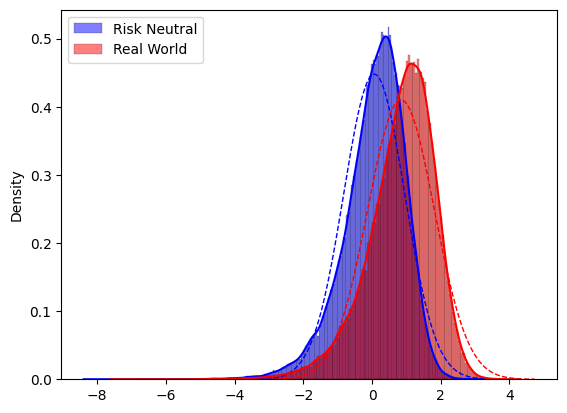

In [110]:
n_steps = 251
n_paths = 100000

st_h_RN, sigma_h_RN, rho_h_RN = HestonProcess.paths(heston_RN, n_paths, n_steps, horizon=15)
st_h_RW, sigma_h_RW, rho_h_RW = HestonProcess.paths(heston_RW, n_paths, n_steps, horizon=15, measure="rw")

obs_ret_s_h_RN = np.log(st_h_RN[:,n_steps] / st_h_RN[:,0])
obs_ret_s_h_RW = np.log(st_h_RW[:,n_steps] / st_h_RW[:,0])

fig, ax = plt.subplots()

sns.histplot(obs_ret_s_h_RN, ax=ax, stat="density", color='blue', label='Risk Neutral', kde=True)
normal(obs_ret_s_h_RN.mean(), obs_ret_s_h_RN.std(), color='blue',linestyle='--')

sns.histplot(obs_ret_s_h_RW, ax=ax, stat="density", color='red', label='Real World', kde=True)
normal(obs_ret_s_h_RW.mean(), obs_ret_s_h_RW.std(), color='red',linestyle='--')

ax.legend()


***Testing BlackScholesEngine w/List of EuropeanVanillaOptions***

In [116]:
bs_engine  = BlackScholesEngine(risk_free_rate = 0.025)
bs_eu_h00_p = bs_engine.npv(options_eu_h00)
